# Image Segmentation using PyTorch

In this notebook, we will perform image segmentation on images stored in the `data/cam1` directory using a pre-trained U-Net model.

## Step 1: Setup and Imports

Before we import the libraries, we need to install the libraries.

In [ ]:
pip install torch torchvision numpy matplotlib opencv-python

Now we can move onto import the necessary libraries.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image

## Step 2: Define the Dataset

We need to define a custom dataset class to handle the images in the `data/cam1` directory.

In [10]:
# Define a simple dataset
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = ImageDataset(image_folder='../data/cam1', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

## Step 3: Load a Pre-trained Model

We will use a pre-trained Fully Convolutional Network (FCN) for segmentation.

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained FCN model
model = fcn_resnet50(pretrained=True)
model = model.to(device)
model.eval()

## Step 4: Perform Segmentation and Visualize Results

We will iterate over the images, perform segmentation, and visualize the results.

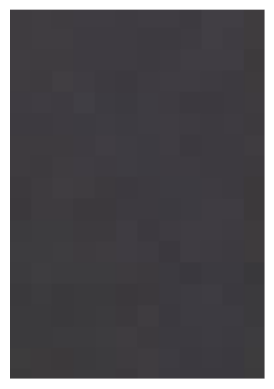

In [11]:
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread('../data/plot_tool.png')
plt.imshow(img)
plt.axis('off')
plt.show()

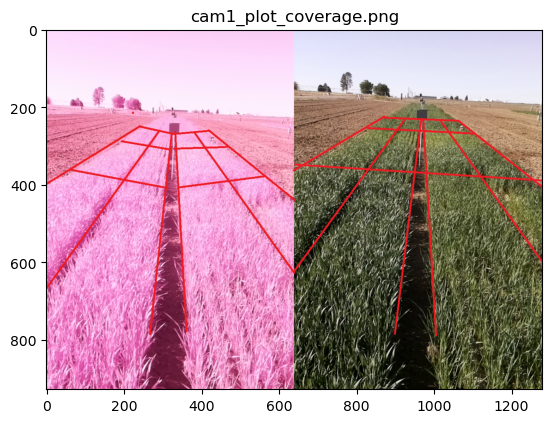

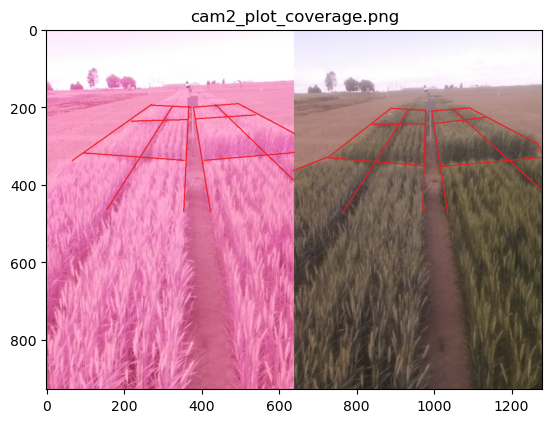

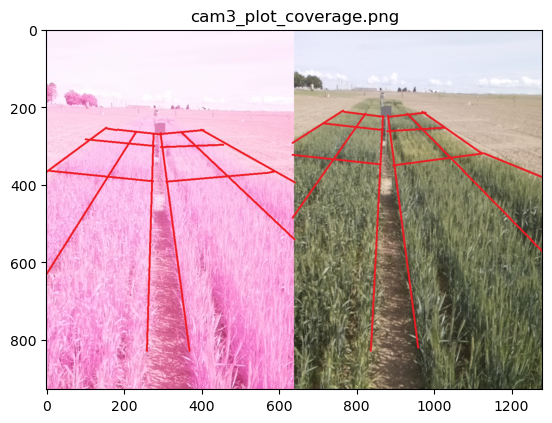

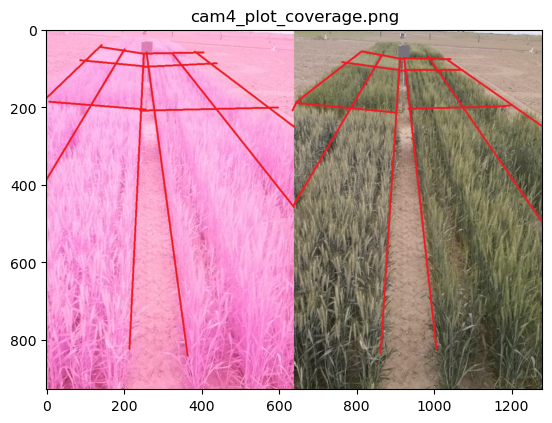

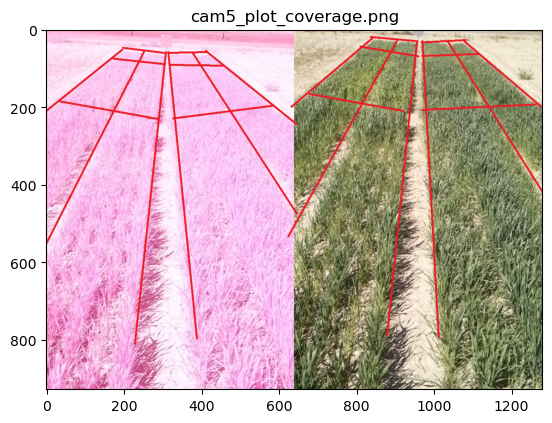

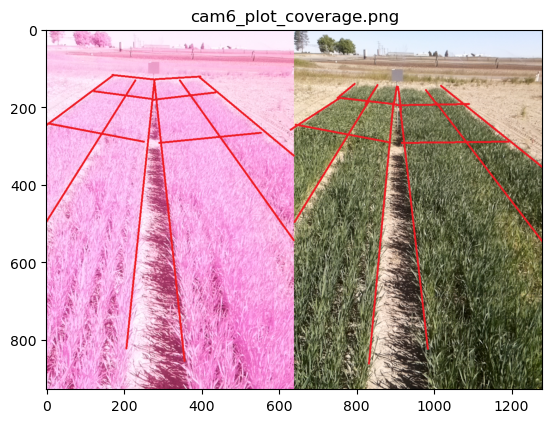

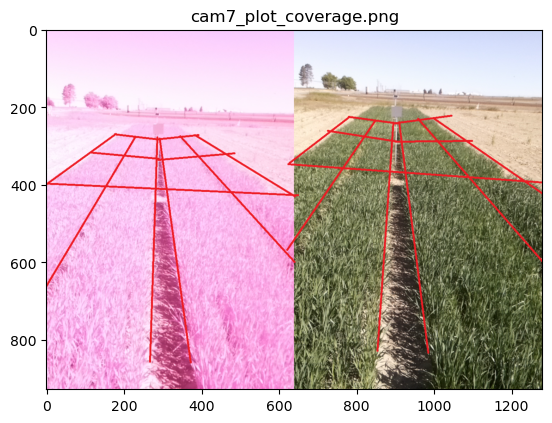

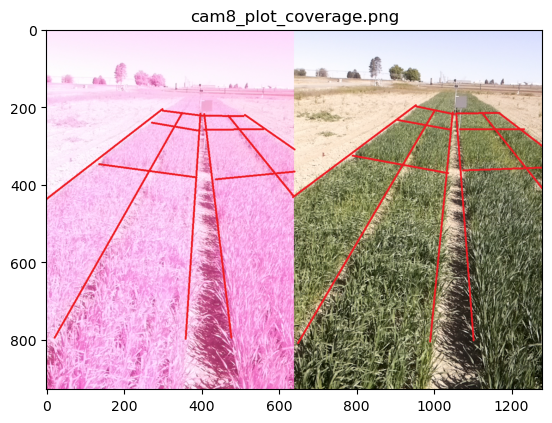

In [12]:
path = '../data/'
image_files = [path + 'cam1_plot_coverage.png', path + 'cam2_plot_coverage.png', path + 'cam3_plot_coverage.png',
               path + 'cam4_plot_coverage.png', path + 'cam5_plot_coverage.png', path + 'cam6_plot_coverage.png',
               path + 'cam7_plot_coverage.png', path + 'cam8_plot_coverage.png']

# Assuming 'image_files' is the list of image file names
for image_file in image_files:
    # Load the image
    img = plt.imread(image_file)

    # Display the image with the title as the image file name
    plt.imshow(img)
    image_file = image_file.replace('../data/', '')
    plt.title(image_file)
    plt.show()


## Splitting 928x1280 image into 2 928x640 images

In [13]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((928, 1280)),
    transforms.ToTensor(),
])

class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Convert RGBA to RGB
        if self.transform:
            image = self.transform(image)
        return image

def split_image(image):
    left_image = image[:, :, :640]
    right_image = image[:, :, 640:]
    return left_image, right_image

# Load the dataset
dataset_folder = '../data/cam1'
output_folder = '../data/cam1_split'
os.makedirs(output_folder, exist_ok=True)
dataset = ImageDataset(image_folder=dataset_folder, transform=transform)

Now let's randomly display 3 images from our new directory `data/cam1_split`

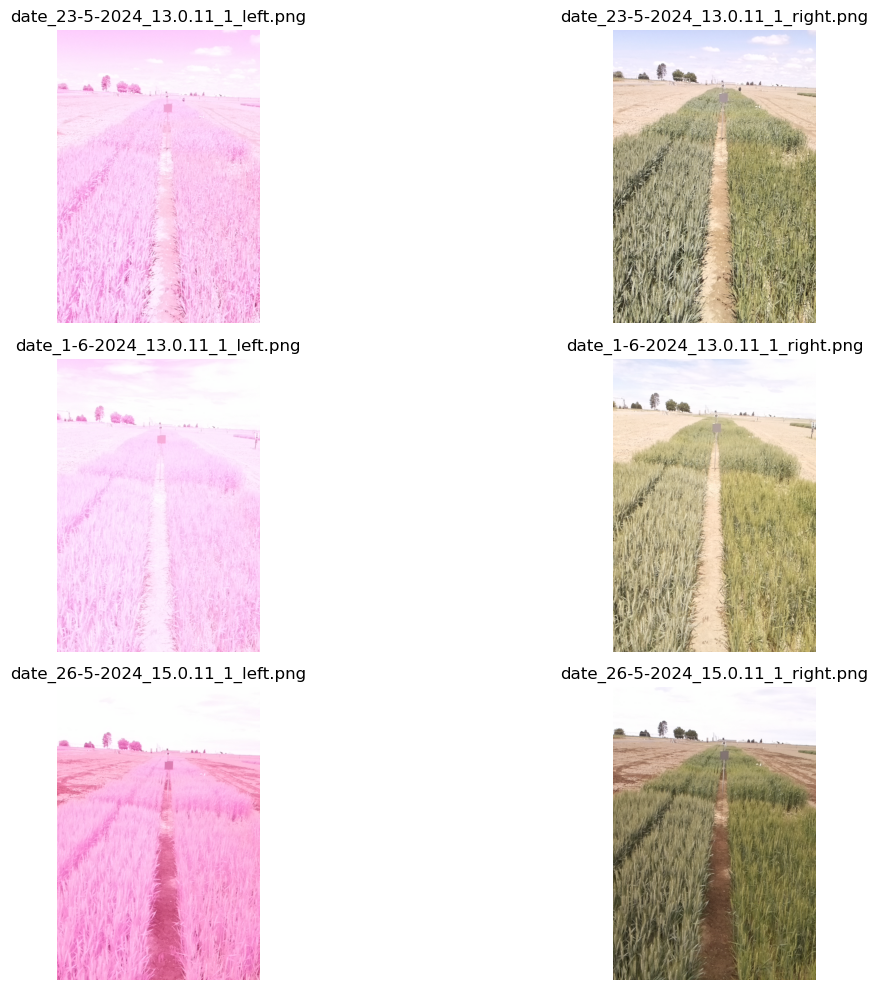

In [14]:
# Get a random sample of 3 images
random_images = random.sample(range(len(dataset)), 3)

# Iterate through the selected images, split them, and display them
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_images):
    image = dataset[idx]  # Get image as a tensor
    left_image, right_image = split_image(image)

    # Convert tensors back to PIL Images
    left_image_pil = transforms.ToPILImage()(left_image)
    right_image_pil = transforms.ToPILImage()(right_image)

    # Save the split images
    base_filename = os.path.splitext(dataset.image_files[idx])[0]
    left_image_pil.save(os.path.join(output_folder, f"{base_filename}_left.png"))
    right_image_pil.save(os.path.join(output_folder, f"{base_filename}_right.png"))

    # Plot the left image
    plt.subplot(3, 2, i*2+1)
    plt.imshow(left_image_pil)
    plt.title(f"{base_filename}_left.png")
    plt.axis('off')

    # Plot the right image
    plt.subplot(3, 2, i*2+2)
    plt.imshow(right_image_pil)
    plt.title(f"{base_filename}_right.png")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Define the folders
split_folder = '../data/cam1_split'
output_folder = '../data/cam1_combined'
os.makedirs(output_folder, exist_ok=True)

# Get the list of left and right images
left_images = [f for f in os.listdir(split_folder) if f.endswith('_left.png')]
right_images = [f for f in os.listdir(split_folder) if f.endswith('_right.png')]

# Ensure that we have matching left and right images
left_images.sort()
right_images.sort()

for left_image_name, right_image_name in zip(left_images, right_images):
    # Load the images
    left_image_path = os.path.join(split_folder, left_image_name)
    right_image_path = os.path.join(split_folder, right_image_name)
    left_image = Image.open(left_image_path)
    right_image = Image.open(right_image_path)
    
    # Ensure both images are of the same size
    if left_image.size != right_image.size:
        print(f"Skipping {left_image_name} and {right_image_name} due to size mismatch.")
        continue
    
    # Create a new blank image with the same size as one of the halves (928x640)
    combined_image = Image.new('RGB', (left_image.width, left_image.height))
    
    # Paste the images
    combined_image.paste(left_image, (0, 0))  # Paste left image at the top
    combined_image.paste(right_image, (0, 0))  # Overlay right image on top
    
    # Save the combined image
    base_filename = left_image_name.replace('_left.png', '')
    combined_image.save(os.path.join(output_folder, f"{base_filename}_combined.png"))

print("Image combination complete.")

Image combination complete.


In [ ]:
# Define the directory path
directory = '../data/cam1_combined'

# Get the list of image files
image_files = [f for f in os.listdir(directory) if f.endswith('.png')]

# Iterate through the image files and display them
for image_file in image_files:
    # Load the image
    image_path = os.path.join(directory, image_file)
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()